In [253]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

[autoreload of mlelec.data.dataset failed: Traceback (most recent call last):
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'QMDataset' object layout differs from 'QMDataset'
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [254]:
import hickle

from ase.io import read

import numpy as np

import torch
torch.set_default_dtype(torch.float64)

from mlelec.data.qmdataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, unfix_orbital_order
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
import metatensor.torch as mts
from metatensor.learn import DataLoader

import os
os.environ["PYSCFAD_BACKEND"] = "torch"
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

from IPython.utils import io as ipy_io

In [1]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"

In [1]:
from pyscf import gto


In [2]:
from pyscfad import numpy as pynp


Using PyTorch backend.


In [1]:
from pyscfad import ops


Using PyTorch backend.


In [2]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf


Using PyTorch backend.


In [255]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },
    'def2tzvp': {
    6: [
        # 5S
        [1, 0, 0],
        [2, 0, 0],
        [3, 0, 0],
        [4, 0, 0],
        [5, 0, 0],
        # 3P
        [2, 1, 1],
        [2, 1, -1],
        [2, 1, 0],
        [3, 1, 1],
        [3, 1, -1],
        [3, 1, 0],
        [4, 1, 1],
        [4, 1, -1],
        [4, 1, 0],
        # 2D
        [3, 2, -2],
        [3, 2, -1],
        [3, 2, 0],
        [3, 2, 1],
        [3, 2, 2],
        [4, 2, -2],
        [4, 2, -1],
        [4, 2, 0],
        [4, 2, 1],
        [4, 2, 2],
        # 1F
        [4, 3, -3],
        [4, 3, -2],
        [4, 3, -1],
        [4, 3, 0],
        [4, 3, 1],
        [4, 3, 2],
        [4, 3, 3]
    ],

     1: [
         # 3S
         [1, 0, 0], 
         [2, 0, 0], 
         [3, 0, 0], 
         # 1P
         [2, 1, -1], 
         [2, 1, 0], 
         [2, 1, 1]
     ]
}
}

device = 'cpu'

In [4]:
max_radial  = 12
max_angular = 6
atomic_gaussian_width = 0.3
cutoff = 3.5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 4

# QMD

In [256]:
workdir = '/scratch/pegolo/ethane'
every = 20

For the moment, we need to create multiple QMDataset (analogous to MoleculeDataset), one for the large basis, one for the small one.

In [261]:
qmdata = QMDataset.from_file(
    frames_path = f'{workdir}/ethane.xyz', 
    fock_realspace_path = f'{workdir}/b3lypg_def2tzvp/focks.npy', 
    overlap_realspace_path = f'{workdir}/b3lypg_def2tzvp/ovlps.npy',
    dimension = 0, 
    device = 'cpu', 
    orbs_name='def2tzvp', 
    orbs=orbitals['def2tzvp'], 
    frame_slice = f'::{every}',
)

In [262]:
qmdata_sto3G = QMDataset.from_file(
    frames_path = f'{workdir}/ethane.xyz', 
    dimension = 0,
    fock_realspace_path = f'{workdir}/b3lypg_sto3g/fock.hickle',
    overlap_realspace_path = f'{workdir}/b3lypg_sto3g/ovlp_nscf.hickle',
    device = device, 
    orbs = orbitals['sto-3g'], 
    orbs_name = 'sto-3g',
    frame_slice = f'::{every}',
)

# MLD

In [272]:
from mlelec.data.mldataset import MLDataset
mldata = MLDataset(qmdata, 
                   item_names = ['fock_blocks', 'fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density'],
                   # features = mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   train_frac = 0.7,
                   val_frac = 0.2,
                   test_frac = 0.1,
                   shuffle = False,
                   model_basis = orbitals['sto-3g'],
                   fix_p_orbital_order = True,
                   aux_overlap_realspace = qmdata_sto3G.overlap_realspace
                  )

cpu pair features
cpu single center features
cpu single center features


# Model

Initialize the model

In [ ]:
# def set_random_seed(seed):
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     # random.seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)

In [ ]:
# from mlelec.models.equivariant_nonlinear_model import EquivariantNonlinearModel
# seed = 0
# set_random_seed(seed)

# model = EquivariantNonlinearModel(mldata, device = device, nhidden = 4, nlayers = 1, activation = 'SiLU', apply_norm = True)
# model = model.double()

In [ ]:
# seed = 0
# set_random_seed(0)

# model_old = LinearModelPeriodic(twocfeat = mldata.features, 
#                             target_blocks = mldata.model_metadata,
#                             frames = mldata.structures, 
#                             orbitals = mldata.model_basis, 
#                             device = device,
#                             nhidden = 4, 
#                             nlayers = 1,
#                             activation = 'SiLU',
#                            apply_norm = True
#                            )
# model_old = model_old.double()

In [372]:
from mlelec.models.equivariant_nonlinear_lightning import LitEquivariantNonlinearModel, MSELoss
from mlelec.models.equivariant_nonlinear_lightning import MLDatasetDataModule
from mlelec.callbacks.logging import LoggingCallback
from mlelec.callbacks.progress_bar import ProgressBar

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping

# Assuming you have `train_dataset`, `val_dataset`, and `test_dataset`
data_module = MLDatasetDataModule(mldata, batch_size=8, num_workers=0)

# Initialize with custom loss function and keyword arguments for derived predictions

model = LitEquivariantNonlinearModel(
    mldata=mldata,
    nhidden=16,
    nlayers=1,
    activation='SiLU',
    apply_norm=True,
    learning_rate=1e-3,
    loss_fn=MSELoss(),
    is_indirect=True,
    eigenvalues=True,
    atom_resolved_density=True
)

In [373]:
logger = TensorBoardLogger("tb_logs", name="ethane")

In [374]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=100,
    verbose=False,
    mode='min'
)

In [375]:
progress_bar = ProgressBar()
logger_callback = LoggingCallback(log_every_n_epochs = 5)

In [376]:
trainer = pl.Trainer(max_epochs=100, 
                     accelerator='cpu', 
                     # logger = logger, 
                     # log_every_n_steps = 1, 
                     check_val_every_n_epoch=10,
                     callbacks=[early_stopping, progress_bar]
                     # callbacks=[early_stopping, logger_callback],
                     # enable_progress_bar=False
                    )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [377]:
trainer.fit(model, data_module)


  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | EquivariantNonlinearModel | 784 K  | train
------------------------------------------------------------
784 K     Trainable params
0         Non-trainable params
784 K     Total params
3.137     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


In [378]:
trainer.test(model, data_module)

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ rmse_atom_resolved_density │    0.24260617104658455     │
│      rmse_eigenvalues      │    0.05181459468415377     │
│         test_loss          │     19.04926153134574      │
└────────────────────────────┴────────────────────────────┘

[{'test_loss': 19.04926153134574,
  'rmse_atom_resolved_density': 0.24260617104658455,
  'rmse_eigenvalues': 0.05181459468415377}]

In [363]:
from mlelec.data.derived_properties import compute_atom_resolved_density, compute_eigenvalues

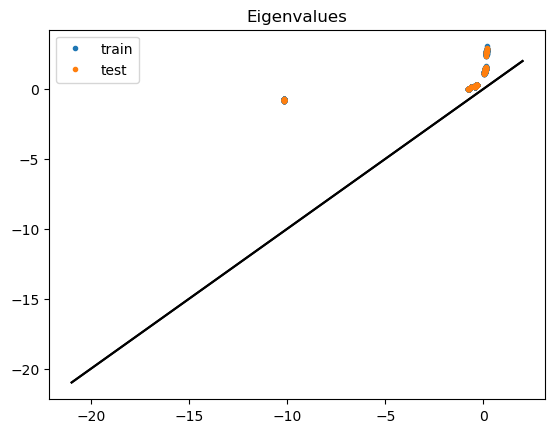

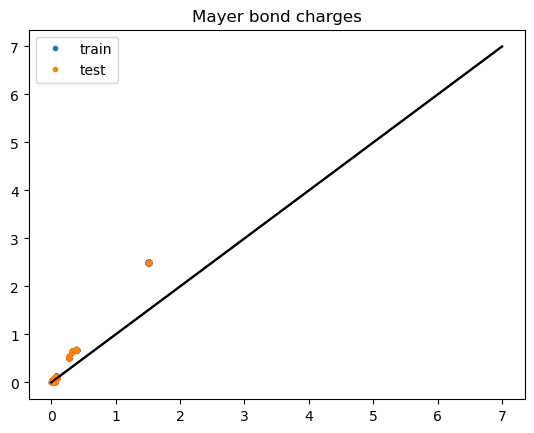

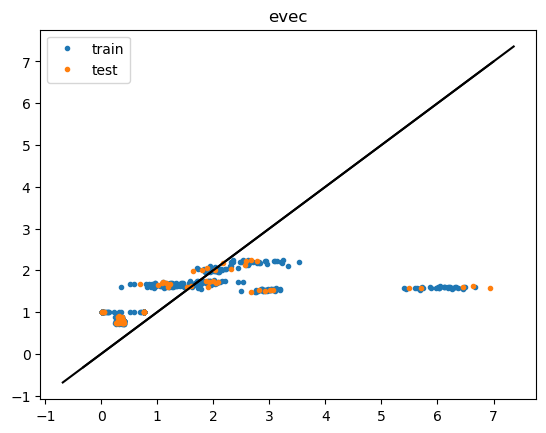

In [371]:
test_dl = DataLoader(mldata.test_dataset, batch_size = len(mldata.test_dataset), collate_fn=mldata.group_and_join)
train_dl = DataLoader(mldata.train_dataset, batch_size = len(mldata.train_dataset), collate_fn=mldata.group_and_join)

test_dl_frames_dict = {A.item(): f for A, f in zip(mldata.test_idx, mldata.test_frames)}
train_dl_frames_dict = {A.item(): f for A, f in zip(mldata.train_idx, mldata.train_frames)}

fig_e, ax_e = plt.subplots()
fig_a, ax_a = plt.subplots()
fig_evec, ax_evec = plt.subplots()

data = {}
for dl_, frames_dict, lbl in zip([train_dl, test_dl], [train_dl_frames_dict, test_dl_frames_dict], ['train', 'test']):
    batch = next(iter(dl_))
    pred = model(batch.features, mldata.model_metadata)

    
    HT = blocks_to_matrix(pred, mldata.model_basis, frames_dict, detach = True)
    HT = [h[0,0,0] for h in HT]

    pred_eigvals, pred_eigvec = compute_eigenvalues(HT, batch.overlap_realspace, return_eigenvectors=True)
    pred_ard, _ = compute_atom_resolved_density(pred_eigvec, 
                                                [mldata.qmdata.structures[i] for i in batch.sample_id], 
                                                 mldata.model_basis, 
                                                 mldata.qmdata.ncore)
    # pred_eigvals, pred_ard, pred_eigvec, pred_rho = compute_ard_vec(qmdata, batch, HT, device, overlap = [qmdata.overlap_realspace[i] for i in batch.sample_id])

    small_shapes = [p.shape for p in pred_eigvals]
    slices = [tuple(slice(0, dim) for dim in small_shape) for small_shape in small_shapes]
    x = torch.cat([batch.eigenvalues[i][s].flatten() for i, s in enumerate(slices)])
    y = torch.cat([p.flatten() for p in pred_eigvals])
    ax_e.plot(x, y, '.', label = lbl)
    ax_e.plot([-21, 2], [-21, 2], 'k')
    ax_e.set_title('Eigenvalues')
    ax_e.legend()

    x = torch.cat([ard.flatten() for ard in batch.atom_resolved_density])
    y = torch.cat([ard.flatten() for ard in pred_ard])
    ax_a.plot(x, y, '.', label = lbl)
    ax_a.plot([0,7], [0,7], 'k')
    ax_a.set_title('Mayer bond charges')
    ax_a.legend()

    small_shapes = [p.shape for p in pred_eigvec]
    slices = [tuple(slice(0, dim) for dim in small_shape) for small_shape in small_shapes]
    x = torch.cat([torch.norm(batch.eigenvectors[i][s], dim = (0)).flatten() for i, s in enumerate(slices)])
    y = torch.cat([torch.norm(p, dim = (0)).flatten() for p in pred_eigvec])
    # pred_evn, targ_evn = torch.norm(pred_eigvec, dim = (1)), torch.norm(batch.eigenvectors[slices], dim = (1))
    
    ax_evec.plot(x, y, '.', label = lbl)
    xmin, xmax = ax_evec.get_xlim()
    ymin, ymax = ax_evec.get_ylim()
    xmin = np.min([xmin,ymin])
    xmax = np.max([xmax,ymax])
    ax_evec.plot([xmin,xmax], [xmin,xmax], 'k')
    ax_evec.set_title('evec')
    ax_evec.legend()

In [347]:
batch = next(iter(test_dl))
print(batch.sample_id)

dl_frames = [qmdata.structures[A] for A in batch.sample_id]
dl_frames_dict = {A: f for A, f in zip(batch.sample_id, dl_frames)}
pred = model(batch.features, mldata.model_metadata)

HT = blocks_to_matrix(pred, mldata.model_basis, dl_frames_dict, detach = True)
HT = [h[0,0,0] for h in HT]

# Predictions need fixing/unfixing the orbital order
fock_predictions = unfix_orbital_order(
    torch.stack(HT),
    dl_frames,
    qmdata_sto3G.basis
)
over_predictions = unfix_orbital_order(
    batch.overlap_realspace,
    dl_frames,
    qmdata_sto3G.basis
)

# QMDataset does NOT need fixing/unfixing the orbital order
fock_targets = torch.stack([qmdata.fock_realspace[i] for i in batch.sample_id])
over_targets = torch.stack([qmdata.overlap_realspace[i] for i in batch.sample_id])

fock_sto3g = torch.stack([qmdata_sto3G.fock_realspace[i] for i in batch.sample_id])
over_sto3g = torch.stack([qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])

with ipy_io.capture_output():
    dipole_targets = compute_dipole_moment(
        dl_frames,
        fock_targets,
        over_targets,
        qmdata.basis_name)

with ipy_io.capture_output():
    dipole_predictions = compute_dipole_moment(
        dl_frames,
        fock_predictions,
        over_predictions,
        qmdata_sto3G.basis_name)

with ipy_io.capture_output():
    dipole_sto3g = compute_dipole_moment(
        dl_frames,
        fock_sto3g,
        over_sto3g,
        qmdata_sto3G.basis_name)

(45, 46, 47, 48, 49)


Text(0, 0.5, 'Predicted dipoles (D)')

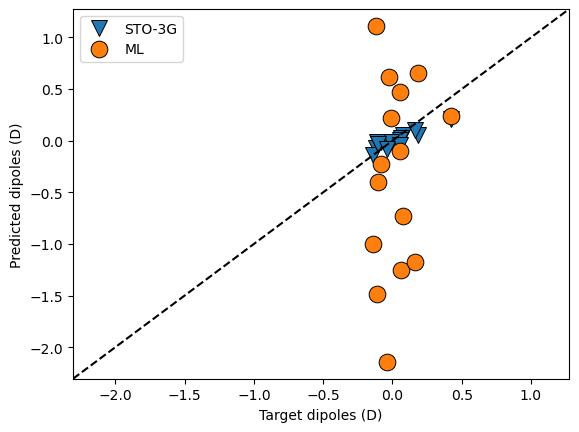

In [349]:
from ase.units import Bohr, Debye
au_to_debye = Bohr/Debye

ms = 12
mew = .7

fig, ax = plt.subplots()

x = dipole_targets.flatten().detach().cpu() * au_to_debye
y_sto3g = dipole_sto3g.flatten().detach().cpu() * au_to_debye
y_ml = dipole_predictions.flatten().detach().cpu() * au_to_debye

rmse_sto3g = np.sqrt(torch.mean(y_sto3g - x)**2)
rmse_ml = np.sqrt(torch.mean(y_ml - x)**2)

ax.plot(x, y_sto3g, 'v', 
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'STO-3G', 
         alpha = 1)

ax.plot(x, y_ml, 'o',
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'ML', 
         alpha = 1)

ax.legend()

xm, xM = ax.get_xlim()
ym, yM = ax.get_ylim()
m = np.min([xm,ym])
M = np.max([xM,yM])
ax.plot([m,M], [m,M], '--k')
ax.set_xlim(m, M)
ax.set_ylim(m, M)

# ax.text(0.6, 0.3, fr'$\mathrm{{RMSE_{{\text{{STO-3G}}}}}}={rmse_sto3g:.3f}\,$D', transform = ax.transAxes, ha = 'left')
# ax.text(0.6, 0.25, fr'$\mathrm{{RMSE_{{ML}}}}={rmse_ml:.3f}\,$D', transform = ax.transAxes, ha = 'left')

ax.set_xlabel('Target dipoles (D)')
ax.set_ylabel('Predicted dipoles (D)')

# ax.set_title('Indirect training from def2-svp to a STO-3G-like model.\nTargets: eigenvalues; ARD; eigenvector norms over AOs\nTest set contains 50 water molecules')